In [ ]:
import pywt
import pywt.data
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shutil
import os
import random
from skimage.transform import resize

Primero creamos la carpeta fotos donde se guardarán las letras segmentadas:

In [ ]:
folder_path = '/fotos'
folder_name = "fotos"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"La carpeta {folder_path} ha sido eliminada.")

else:
    print(f"La carpeta {folder_path} no existe.")

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

La carpeta /fotos ha sido eliminada.


Ahora cargamos nuestra imagen y la transformamos a escala de grises:

In [ ]:
image_path_in_colab="im_carlos.jpeg"

image = cv2.imread(image_path_in_colab)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Ahora, aplicamos el algoritmo de canny para detectar los bordes de la imagen, pasando a negro todo lo demás:

In [ ]:
edged_image = cv2.Canny(gray, threshold1=30, threshold2=100)

Ahora procedemos a segmentar la imagen detectando las letras como componentes conectados (agrupaciones conectadas entre sí). Gracias a realzar tanto los bordes, esta clasificación es posible, ya que son los que permite que el algoritmo detecte las componentes conectadas.

In [ ]:
regiones_recortadas = []
areas=[]
_, labels, stats, centroids = cv2.connectedComponentsWithStats(edged_image)

for i, stat in enumerate(stats):
    area = stat[cv2.CC_STAT_AREA]

    if area > 100 and area < 700:
        areas.append(area)

        x, y, w, h = stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP], stat[cv2.CC_STAT_WIDTH], stat[cv2.CC_STAT_HEIGHT]

        roi = edged_image[y:y+h, x:x+w]
        centroide = centroids[i]
        regiones_recortadas.append((roi, centroide))

Debido a tener una imagen sin relleno, en letras como la O donde no todos los bordes están conectados entre sí detecta más de una letra. Para solucionarlo, vamos a ordenar estas componentes por area, y después vamos a eliminar una letra si está muy cerca de otra (centroides cercanos) y su area es más pequeña (para quedarnos con la letra más grande, que suele ser la original).

In [ ]:
indices = list(range(1, len(areas)))

indices_ordenados = sorted(indices, key=lambda i: areas[i - 1], reverse=True)

regiones_recortadas = [regiones_recortadas[i] for i in indices_ordenados]

distancia_minima = 40

regiones_finales = []
centroides_procesados = []

for region, centroide in regiones_recortadas:
    duplicada = False
    for centroide_procesado in centroides_procesados:
        distancia = np.sqrt(((centroide[0] - centroide_procesado[0]) ** 2) + ((centroide[1] - centroide_procesado[1]) ** 2))
        if distancia < distancia_minima:
            duplicada = True
            break

    if not duplicada:
        regiones_finales.append((region, centroide))
        centroides_procesados.append(centroide)

regiones_finales = sorted(regiones_finales, key=lambda x: (x[1][0], x[1][1]))

Ahora, para que nuestra red funcione correctamente, necesitamos que la letra no este hueca. Para solucionarlo, vamos a engrosar los bordes para rellenar la letra:

In [ ]:
regiones_rellenadas = []
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

for region, centroide in regiones_finales:
    dilated_region = cv2.dilate(region, kernel, iterations=3)
    regiones_rellenadas.append((dilated_region, centroide))

In [ ]:
regiones_redimensionadas=[]
for i, (region, _) in enumerate(regiones_rellenadas):

    border_size = int(region.shape[0] * .2)  #Porcentaje del 20 % del tamaño de la imagen como borde

    # Crea el borde negro alrededor de la imagen
    image_with_border = cv2.copyMakeBorder(
    region,
    top=border_size,
    bottom=border_size,
    left=border_size,
    right=border_size,
    borderType=cv2.BORDER_CONSTANT,
    value=[0, 0, 0]
    )

    regiones_redimensionadas.append(image_with_border)

Por último, mostramos y guardamos las letras encontradas:

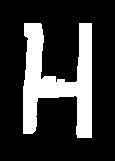

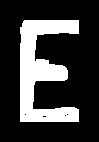

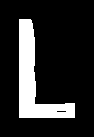

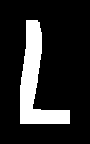

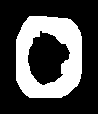

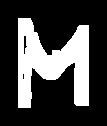

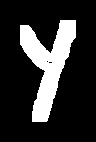

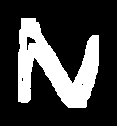

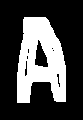

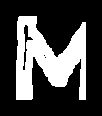

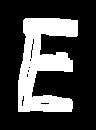

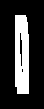

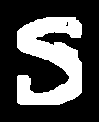

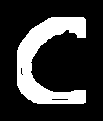

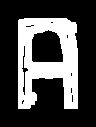

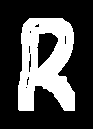

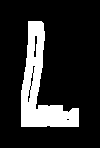

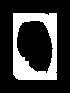

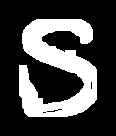

In [ ]:
for i, region in enumerate(regiones_redimensionadas):
    cv2.imwrite(os.path.join(folder_path, f'letra_{i}.png'), region)

    plt.imshow(region)

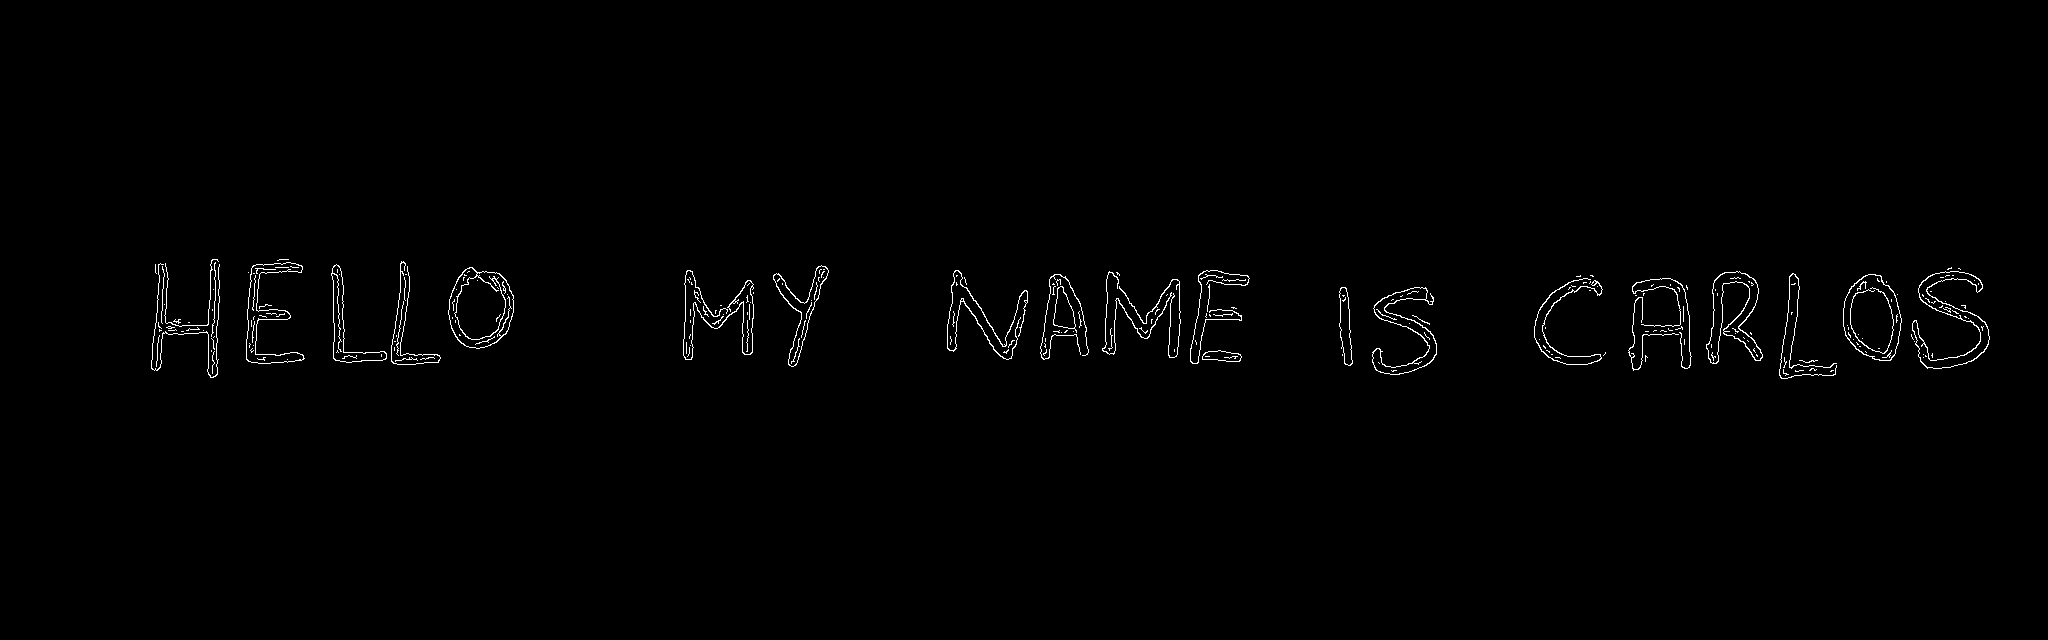

In [ ]:
plt.imshow(edged_image)